# MLFlow for Kaggle I - Loan Approval Prediction

In this notebook we will use the Loan Approval dataset to demonstrate how to build a machine learning pipeline using the MLFlow library. We will use the following steps:

1. Data Collection
2. Data Preprocessing
3. Train, Test, Validation Split
4. Model Training
5. Model Evaluation
6. Model Tracking
7. Kaggle Submission
8. BONUS: Exercises

## 1. Data Collection

### Loan Approval Prediction

We are going to take the data form kaggle, so we need to install the kaggle library and download the data. Here is the link to the Loan Approval Prediction: https://www.kaggle.com/competitions/playground-series-s4e10/overview. In order to start this competition we need to **manually join the competition** to accept the terms and conditions.

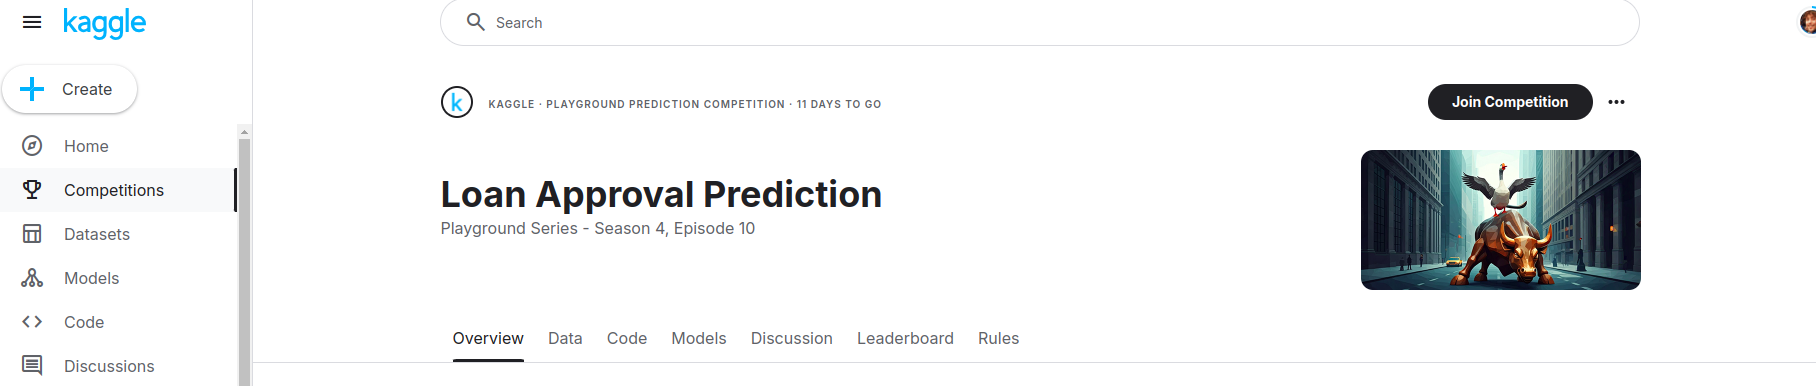

We then need to get an API TOKEN from kaggle. To do this we need to go to the kaggle website, click on the profile icon and then click on "My Account". In the "API" section we can click on "Create New API Token" to download the token. We then need to move the token to the `~/.kaggle` folder and rename it to `kaggle.json`.

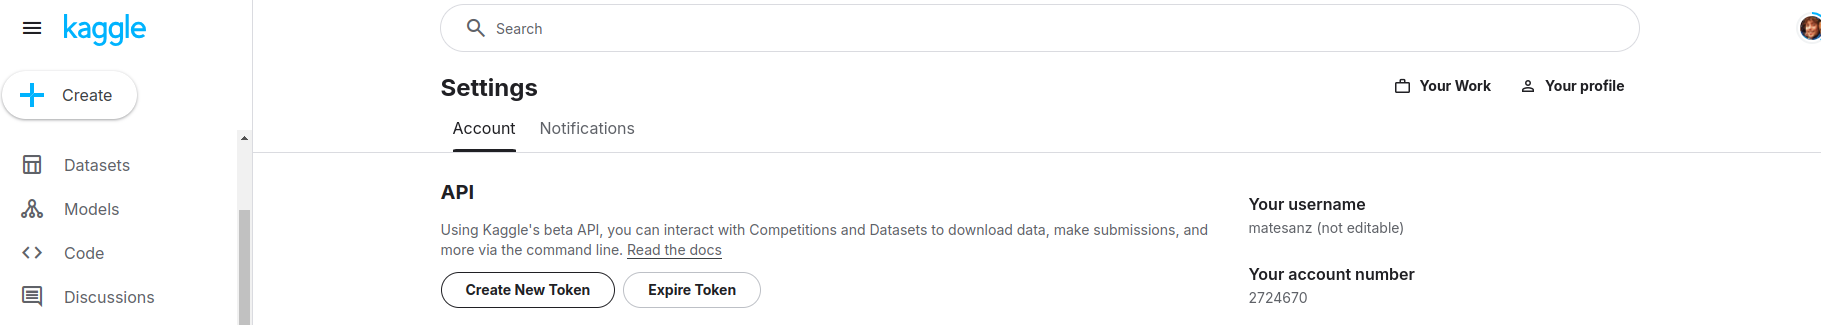

Once we've join the competition we can download the data using the following commands:

```bash
pip install kaggle
kaggle competitions download -c playground-series-s4e10
```

You also have the option to **download the data manually** by going to `Data` > `Download Data`

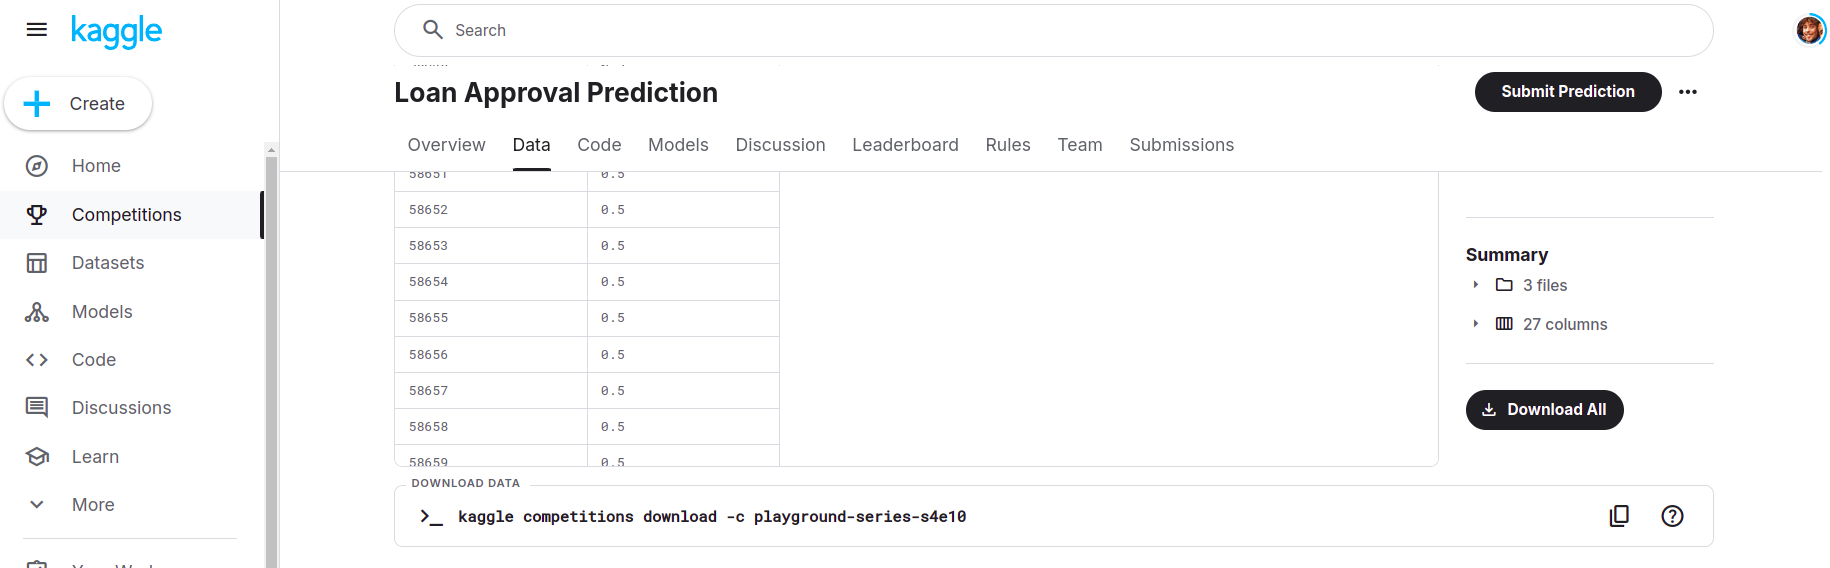

Once we've downloaded the data we are going to save it into `data/loan_prediciton`. We can see there are three files:

- `train.csv`: The training data
- `test.csv`: The test data
- `sample_submission.csv`: The sample submission file

ℹ️ Remember that `test.csv` does not have the target column, we will use it to evaluate our model against the kaggle platform.

### Explore the data

Let's load the data and take a look at the first few rows.

In [16]:
import warnings
warnings.filterwarnings('ignore')


In [17]:
import pandas as pd


DATA_FOLDER = "../data/loan_prediction/"
TRAIN_CSV_PATH = DATA_FOLDER + "train.csv"
TEST_CSV_PATH = DATA_FOLDER + "test.csv"

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

data_df = pd.concat([train_df, test_df], keys=["train", "test"])
data_df.head()

id  person_age  person_income person_home_ownership  \
train 0   0          37          35000                  RENT   
      1   1          22          56000                   OWN   
      2   2          29          28800                   OWN   
      3   3          30          70000                  RENT   
      4   4          22          60000                  RENT   

         person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
train 0                0.0   EDUCATION          B       6000          11.49   
      1                6.0     MEDICAL          C       4000          13.35   
      2                8.0    PERSONAL          A       6000           8.90   
      3               14.0     VENTURE          B      12000          11.11   
      4                2.0     MEDICAL          A       6000           6.92   

         loan_percent_income cb_person_default_on_file  \
train 0                 0.17                         N   
      1                 0.07                         N   
      2                 0.21                         N   
      3                 0.17                         N   
      4                 0.10                         N   

         cb_person_cred_hist_length  loan_status  
train 0                          14          0.0  
      1                           2          0.0  
      2                          10          0.0  
      3                           5          0.0  
      4                           3          0.0

In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97743 entries, ('train', 0) to ('test', 39097)
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97743 non-null  int64  
 1   person_age                  97743 non-null  int64  
 2   person_income               97743 non-null  int64  
 3   person_home_ownership       97743 non-null  object 
 4   person_emp_length           97743 non-null  float64
 5   loan_intent                 97743 non-null  object 
 6   loan_grade                  97743 non-null  object 
 7   loan_amnt                   97743 non-null  int64  
 8   loan_int_rate               97743 non-null  float64
 9   loan_percent_income         97743 non-null  float64
 10  cb_person_default_on_file   97743 non-null  object 
 11  cb_person_cred_hist_length  97743 non-null  int64  
 12  loan_status                 58645 non-null  float64
dtypes: float64

In [19]:
train_df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

## 2. Data Preprocessing

Remember that we need to preprocess the data before training the model. We will do the following steps:

### Encode Categorical Variables

As an example we will use the `LabelEncoder` to encode the `object` columns.

In [20]:
from sklearn.preprocessing import LabelEncoder


encoded_df = data_df.copy()
cat_columns = data_df.select_dtypes(include=["object"]).columns
for col in cat_columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(data_df[col])

encoded_df.head()

id  person_age  person_income  person_home_ownership  \
train 0   0          37          35000                      3   
      1   1          22          56000                      2   
      2   2          29          28800                      2   
      3   3          30          70000                      3   
      4   4          22          60000                      3   

         person_emp_length  loan_intent  loan_grade  loan_amnt  loan_int_rate  \
train 0                0.0            1           1       6000          11.49   
      1                6.0            3           2       4000          13.35   
      2                8.0            4           0       6000           8.90   
      3               14.0            5           1      12000          11.11   
      4                2.0            3           0       6000           6.92   

         loan_percent_income  cb_person_default_on_file  \
train 0                 0.17                          0   
      1                 0.07                          0   
      2                 0.21                          0   
      3                 0.17                          0   
      4                 0.10                          0   

         cb_person_cred_hist_length  loan_status  
train 0                          14          0.0  
      1                           2          0.0  
      2                          10          0.0  
      3                           5          0.0  
      4                           3          0.0

### Data Correlation

Let's take a look at the correlation between the features and the target variable

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x782806b1f690>


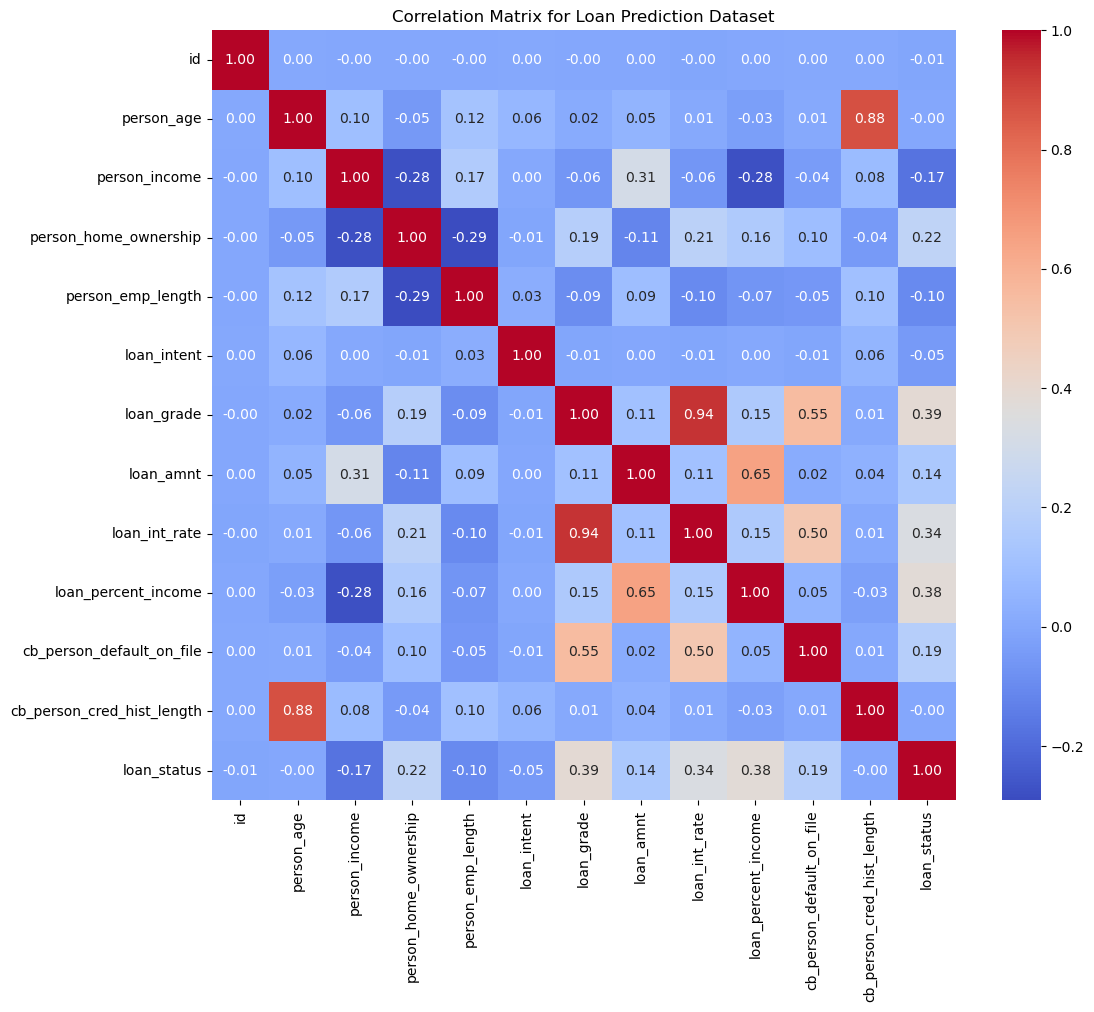

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


CORRELATION_IMAGE_PATH = DATA_FOLDER + "correlation_matrix.png"

# plot the correlation matrix
corr = encoded_df.corr()
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Matrix for Loan Prediction Dataset")

# save the image to upload it to mlflow as an artifact
fig.savefig(CORRELATION_IMAGE_PATH)

## 3. Train, Test, Validation split

We now split the the dataframe into training and validation sets. We will use the training set to train the model and the validation set to evaluate the model. Finally, we will use the test set to generate the predictions and send them to the kaggle platform.

In [22]:
from sklearn.model_selection import train_test_split


TEST_SIZE = 0.2
RANDOM_STATE = 42

train_df = encoded_df.loc["train"]


X = train_df.drop(columns=["loan_status"])
y = train_df["loan_status"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 4. Model Training

Once we have preprocessed the data we can train the model.

In [23]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Model Evaluation

This competition uses the **Area Under the Curve (AUC)** as the evaluation metric.

In [24]:
from sklearn.metrics import roc_auc_score


y_val_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.4f}")

Validation AUC: 0.8450


### Generate submission file

Looking at the `submission_sample.csv` file we see that it hmut have two columns: `id` and `loan_status`. The `id` column must have the same values as the test set and the `loan_status` column must have the predictions.

In [25]:
# Save the CSV to be submitted to a file
SUBMISSION_CSV_PATH = DATA_FOLDER + 'submission.csv'

# get the input data of the test set
test_df = encoded_df.loc["test"]
test_df = test_df.drop(columns=["loan_status"])

# obtain the predictions
y_test_pred = model.predict(test_df)

# prepare the data to be submitted
ids_column = test_df["id"]
submission_data = {
    "id": ids_column,
    "loan_status": y_test_pred
}

# save it to a CSV file
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv(SUBMISSION_CSV_PATH, index=False)
submission_df.head()

,id,loan_status
0,58645,1.0
1,58646,0.0
2,58647,1.0
3,58648,0.0
4,58649,0.0


## 6. Model Tracking

Once we have trained the model we can use the MLFlow library to track the model performance. We can log the AUC, the metrics, the submission file...

### Connect to MLFlow

In [26]:
import mlflow


MLFLOW_TRACKING_URI = "http://localhost:5000" 

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("loan_prediction")

DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/experiments/get-by-name?experiment_name=loan_prediction HTTP/1.1" 200 271


<Experiment: artifact_location='mlflow-artifacts:/198316915909889442', creation_time=1736960267268, experiment_id='198316915909889442', last_update_time=1736960267268, lifecycle_stage='active', name='loan_prediction', tags={}>

### Submit to MLFlow

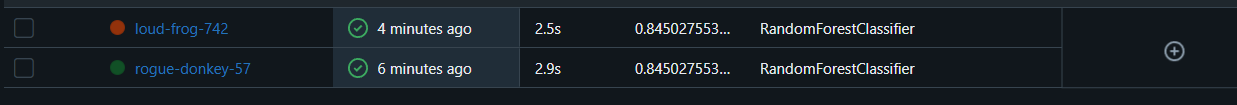

In [27]:
with mlflow.start_run():

    # log a tag to identify the model
    mlflow.set_tag("model", "RandomForestClassifier")

    # log the evaluation metric
    mlflow.log_metric("auc", auc)

    # log the correlation matrix image and the submission CSV
    mlflow.log_artifact(CORRELATION_IMAGE_PATH)
    mlflow.log_artifact(SUBMISSION_CSV_PATH)

    # log the model itself
    mlflow.sklearn.log_model(model, "my_logged_model")

DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/create HTTP/1.1" 200 939
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/set-tag HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-metric HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/runs/get?run_uuid=37d1576621d44834907ca3c2ddc44d2d&run_id=37d1576621d44834907ca3c2ddc44d2d HTTP/1.1" 200 1199
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "PUT /api/2.0/mlflow-artifacts/artifacts/198316915909889442/37d1576621d44834907ca3c2ddc44d2d/artifacts/correlati

🏃 View run worried-lynx-661 at: http://localhost:5000/#/experiments/198316915909889442/runs/37d1576621d44834907ca3c2ddc44d2d
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


## 7. Kaggle Submission

Finally we can submit the predictions to the kaggle platfrom. To do so we are going to retrieve the submission CSV from the best MLFlow run and submit it to the kaggle platform.

### Get the best run

In [31]:
runs = mlflow.search_runs(order_by=['metrics.auc DESC'])
best_run_id = runs.iloc[0]["run_id"]
best_run_name = runs.iloc[0]["tags.mlflow.runName"]
f"Best run: {best_run_name} (run_id: {best_run_id})"

DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/search HTTP/1.1" 200 43047


'Best run: worried-lynx-661 (run_id: 37d1576621d44834907ca3c2ddc44d2d)'

### Download the submission file

In [32]:
import logging
logging.basicConfig(level=logging.DEBUG)


In [33]:
from pathlib import Path
from mlflow import MlflowClient


client = MlflowClient()
submission_filename = Path(SUBMISSION_CSV_PATH).name
submision_csv_path = client.download_artifacts(best_run_id, submission_filename, DATA_FOLDER)

DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow-artifacts/artifacts?path=198316915909889442%2F37d1576621d44834907ca3c2ddc44d2d%2Fartifacts%2Fsubmission.csv HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost


### Submit to Kaggle

You could upload the results manually by going to the kaggle website and clicking on `Submit Predictions`. You can then upload the file and submit it. Or you can use the kaggle API to submit the file:

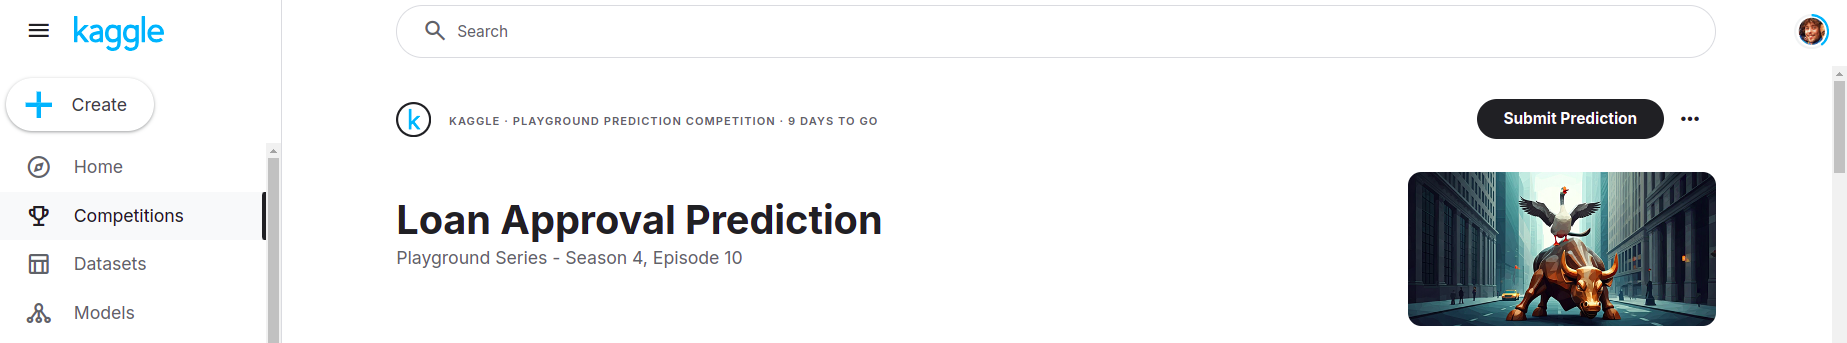

### 🎉 My Submission!:

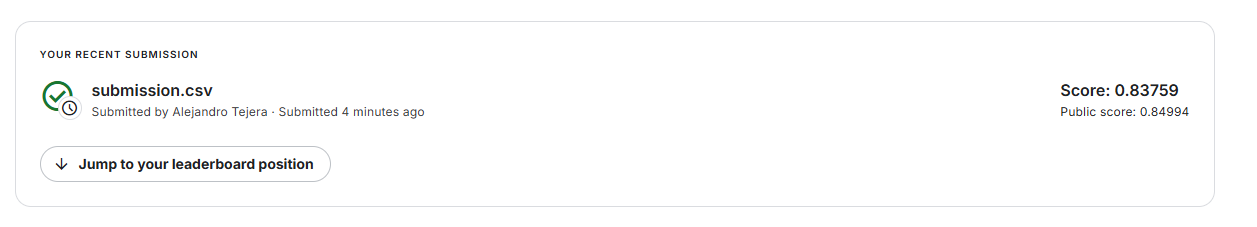


## Bonus: Exercises

Now improve this notebook by doing the following exercises:

1. Log the Correlation Heatmap to MLflow

In [54]:

# La ruta a la imagen de la matriz de correlación
image_path = "/workspaces/Python-classes/data/loan_prediction/correlation_matrix.png"

# Comienza un nuevo run de MLflow
with mlflow.start_run():
    # Log the image as an artifact
    mlflow.log_artifact(image_path, "correlation_matrix")

# Finaliza el run de MLflow
mlflow.end_run()


🏃 View run overjoyed-auk-169 at: http://localhost:5000/#/experiments/198316915909889442/runs/621c50816195420582aa023ecd1da277
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


2. Model Tracking: log the model parameters to MLFlow

In [55]:
import mlflow
from sklearn.ensemble import RandomForestRegressor

# Initial MLflow setup
MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("loan_prediction")

# Model parameters
n_estimators = 100
max_depth = 3
random_state = 42

# Model configuration
model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

# Train the model (assuming you have X_train and y_train)
# model.fit(X_train, y_train)

# Start an MLflow run
with mlflow.start_run():
    # Logging model parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    
    # Optionally: If you have evaluation metrics, you can also log them
    # accuracy = model.score(X_test, y_test)
    # mlflow.log_metric("accuracy", accuracy)
    
    # Save the model as an artifact
    mlflow.sklearn.log_model(model, "random_forest_model")

# End the run
mlflow.end_run()



2025/01/15 17:43:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run judicious-vole-35 at: http://localhost:5000/#/experiments/198316915909889442/runs/33807ae352ef41c89b3b42c8d748f701
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


3. Model Training: try another model from the `sklearn` library log the results and compare them in MLFLow


In [23]:
import mlflow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generate some synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# MLflow setup
MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("loan_prediction")

# Start an MLflow run
with mlflow.start_run():

    # Configure and train the logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Log parameters
    mlflow.log_params({
        "solver": model.get_params()["solver"],
        "penalty": model.get_params()["penalty"],
        "C": model.get_params()["C"],
        "random_state": model.get_params()["random_state"]
    })

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)

    # Log model
    mlflow.sklearn.log_model(model, "logistic_regression_model")

# End the run
mlflow.end_run()


DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/experiments/get-by-name?experiment_name=loan_prediction HTTP/1.1" 200 271
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost


DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/create HTTP/1.1" 200 945
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "POST /api/2.0/mlflow/runs/log-metric HTTP/1.1" 200 2
2025/01/15 19:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/runs/get?run_uuid=80a17e968617443388d18b7d14c7ac66&run_id=80a17e968617443388d18b7d14c7ac66 HTTP/1.1" 200 1426
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http:

🏃 View run monumental-wren-624 at: http://localhost:5000/#/experiments/198316915909889442/runs/80a17e968617443388d18b7d14c7ac66
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


4. Model Training: try another models from other libraries like `xgboost`, `lightgbm`, `catboost`... and compare the results


In [24]:
import mlflow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import xgboost as xgb
import lightgbm as lgb

# Generate some synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# MLflow setup
MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("loan_prediction")

# Define and train models
models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Log parameters
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        
        # Log model
        mlflow.sklearn.log_model(model, name)

# End MLflow run
mlflow.end_run()


DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.viewing.view(['quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
DEBUG:graphviz._tools:deprecate posit

DEBUG:graphviz._tools:deprecate positional args: graphviz.saving.Save.save(['directory'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.rendering.Render.render(['directory', 'view', 'cleanup', 'format', 'renderer', 'formatter', 'neato_no_op', 'quiet', 'quiet_view'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.rendering.Render.view(['directory', 'cleanup', 'quiet', 'quiet_view'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.unflattening.Unflatten.unflatten(['stagger', 'fanout', 'chain'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.graphs.BaseGraph.__init__(['comment', 'filename', 'directory', 'format', 'engine', 'encoding', 'graph_attr', 'node_attr', 'edge_attr', 'body', 'strict'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.sources.Source.from_file(['directory', 'format', 'engine', 'encoding', 'renderer', 'formatter'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.sources.Source.__init__(['filename', 'direct

🏃 View run XGBoost at: http://localhost:5000/#/experiments/198316915909889442/runs/acd5af03077c42158b7a49ff9eea3866
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442
[LightGBM] [Info] Number of positive: 365, number of negative: 385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5010
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486667 -> initscore=-0.053346
[LightGBM] [Info] Start training from score -0.053346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

2025/01/15 19:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "GET /api/2.0/mlflow/runs/get?run_uuid=c777106837db4cd5939afc18f9aef8d8&run_id=c777106837db4cd5939afc18f9aef8d8 HTTP/1.1" 200 2623
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "PUT /api/2.0/mlflow-artifacts/artifacts/198316915909889442/c777106837db4cd5939afc18f9aef8d8/artifacts/LightGBM/requirements.txt HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Resetting dropped connection: localhost
DEBUG:urllib3.connectionpool:http://localhost:5000 "PUT /api/2.0/mlflow-artifacts/artifacts/198316915909889442/c777106837db4cd5939afc18f9aef8d8/artifacts/LightGBM/MLmodel HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:Res

🏃 View run LightGBM at: http://localhost:5000/#/experiments/198316915909889442/runs/c777106837db4cd5939afc18f9aef8d8
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


5. Model Evaluation: try another metrics (which metrics should we use for a classification problem?) and log them to MLFlow

2025/01/15 18:07:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run classy-duck-552 at: http://localhost:5000/#/experiments/198316915909889442/runs/aa807134d1fb41419940e94b81d1dc31
🧪 View experiment at: http://localhost:5000/#/experiments/198316915909889442


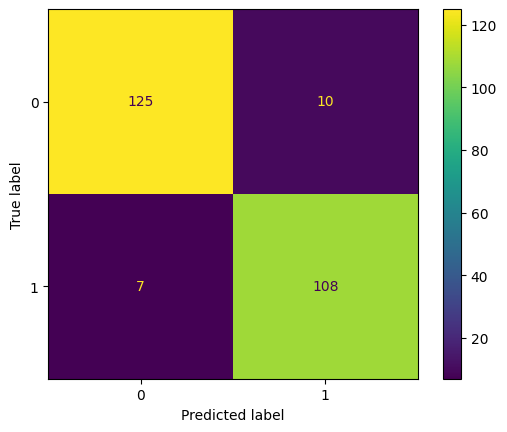

In [66]:
import mlflow
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generate synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# MLflow setup
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("loan_prediction")

# Define the model
model = RandomForestClassifier(random_state=42)
with mlflow.start_run():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

    # Calculate metrics
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision = metrics.precision_score(y_test, predictions, average='binary')
    recall = metrics.recall_score(y_test, predictions, average='binary')
    f1 = metrics.f1_score(y_test, predictions, average='binary')
    roc_auc = metrics.roc_auc_score(y_test, probabilities)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Log model
    mlflow.sklearn.log_model(model, "random_forest_classifier")

    # Optionally, log the confusion matrix as an artifact
    cm = metrics.confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

mlflow.end_run()



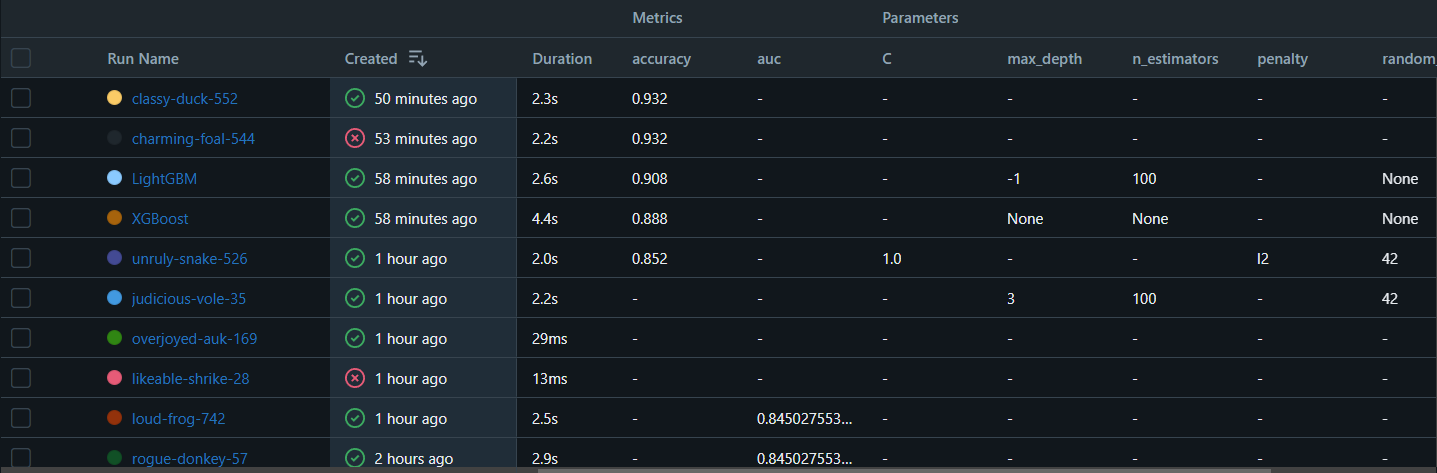

6. Think about the train-test-validation split. How can we improve our model generalization? 


In [67]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your data and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


7. Model Evaluation: Think about the evaluation we are doing. Is it correct? How can we improve it?

Stratified Split: If loan_status is a categorical target variable and especially if it's imbalanced (some classes have many more samples than others), consider using the stratify parameter in train_test_split to ensure that your train and validation sets have the same proportion of classes as the original dataset.

Cross-Validation: For a more robust model evaluation, especially when you have a limited amount of data, consider using cross-validation instead of a single train-validation split. This approach will use different portions of your data as the validation set across multiple iterations, which provides a better estimation of your model's performance.

Logging More Details in MLflow: Considering logging not only model parameters and metrics but also details like feature importance, and even validation strategies and splitting summaries to provide more context about the training process in your MLflow logs.



In [68]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
